# Comprehensive BTCUSDT Data Analysis and Modeling with Binance Raw Trade Data
### According to Advances in Machine Learning - Marcos López de Prado

In [2]:
# Import necessary libraries
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, classification_report

from multiprocessing import Pool, cpu_count
from utils.data_analysis import adf_stat, fractional_difference, calculate_high_low_volatility_k1, calculate_high_low_volatility_k2, auto_reg, load_trades_from_parquet
from utils.kfold import PurgedKFold
%matplotlib inline
plt.style.use('mpl15') # 'mpl20': 'default', 'mpl15': 'classic'

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


# Configure Logging
Set up logging to display information during execution.

In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


Functions

In [3]:
def plot_autocorrelation(frac_close, lags):

    # ACF plot
    fig, ax = plt.subplots(figsize=(10,6))
    plot_acf(frac_close.dropna(), lags=lags, ax=ax)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()

    # PACF plot
    fig, ax = plt.subplots(figsize=(10,6))
    plot_pacf(frac_close.dropna(), lags=lags, ax=ax, method='ywm')
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.show()

# Define Functions for Data Loading and Bar Creation
We define functions to load trade data in chunks and to create different types of bars.

In [4]:
# Input date range for data loading
start_date = '2016-01-01'  # Set your start date
end_date = '2023-12-31'    # Set your end date
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

directory = 'binance-btcusdt-dollar-bars-10M'
df = load_trades_from_parquet(directory, start_date, end_date)

Sample period analisys

In [5]:
df['time_diff'] = df['time'].diff()
df['diff_time_minutes'] = df['time_diff'].dt.total_seconds() / 60
mean_diff_minutes = df['time_diff'].mean().total_seconds() / 60
print(f"Média da diferença de tempo em minutos: {mean_diff_minutes:.2f} minutos")

# Definir uma lista de percentis desejados
percentis = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
df.set_index('time', inplace=True)

# Calcular os percentis
percentis_valores = df['diff_time_minutes'].quantile(percentis)

# Exibir os resultados
print("Percentis da diferença de tempo em minutos:")
print(percentis_valores)



Média da diferença de tempo em minutos: 8.86 minutos
Percentis da diferença de tempo em minutos:
0.10     0.798283
0.25     1.693450
0.50     3.641483
0.75     7.781900
0.90    18.586433
0.95    33.878450
0.99    81.264775
Name: diff_time_minutes, dtype: float64


# Visualize Bars
Plot the close prices of different bars.

In [6]:
# # Plot dollar run bars
# if not df.empty:
#     plt.figure(figsize=(12,6))
#     plt.plot(df['time'], df['close'])
#     plt.title('Dollar Run Bars Close Price 10M')
#     plt.xlabel('Time')
#     plt.ylabel('Price')
#     plt.show()
# else:
#     print("Dollar run bars are empty.")


## Stationarity Test
Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity.

In [7]:
df['hl_vol_k1'] = calculate_high_low_volatility_k1(df)
df['hl_vol_k2'] = calculate_high_low_volatility_k2(df)

ADF Statistic: -60.151434497849486
p-value: 0.0
Critical Value (1%): -3.430
Critical Value (5%): -2.862
Critical Value (10%): -2.567
Rejected the null hypothesis - time series is stationary.


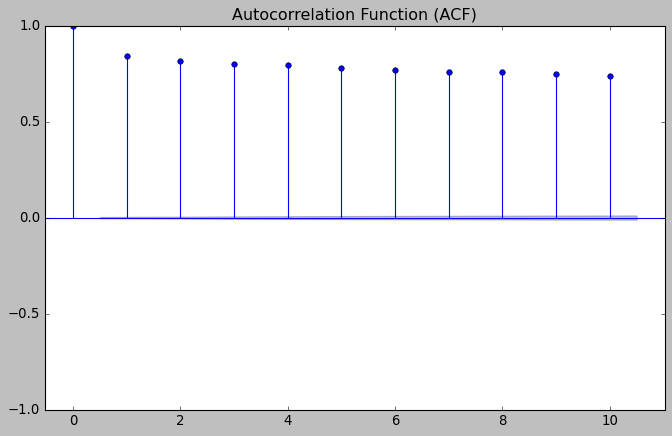

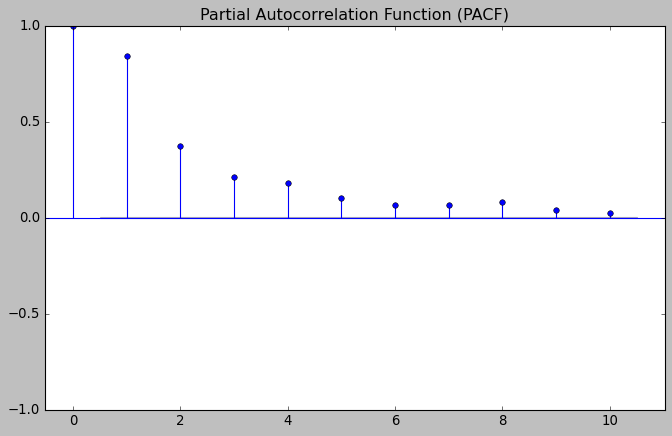

In [9]:
lag=10

stat = adf_stat(df['hl_vol_k1'], n=lag, downsample=False)

plot_autocorrelation(df['hl_vol_k1'], lags=lag)

ADF Statistic: -24.504770905067815
p-value: 0.0
Critical Value (1%): -3.430
Critical Value (5%): -2.862
Critical Value (10%): -2.567
Rejected the null hypothesis - time series is stationary.


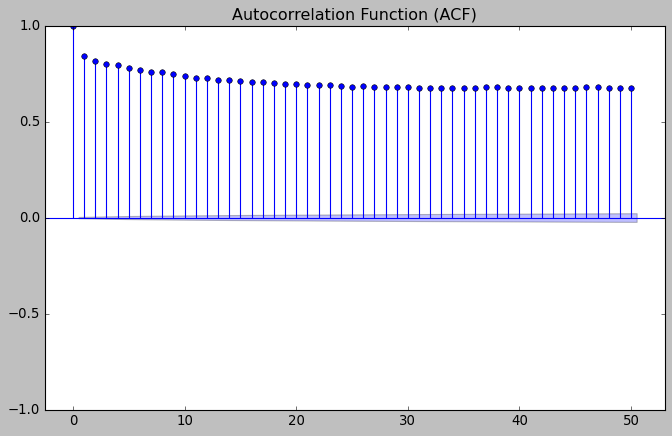

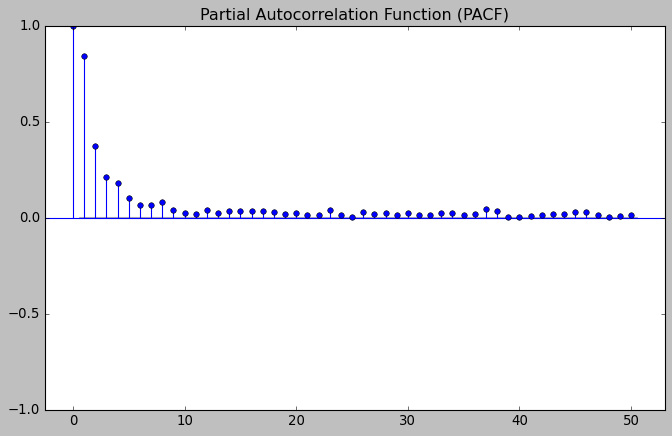

In [ ]:
adf_stat(df['hl_vol_k2'], n=50, downsample=False)

# ACF plot
fig, ax = plt.subplots(figsize=(10,6))
plot_acf(df['hl_vol_k2'], lags=50, ax=ax)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
fig, ax = plt.subplots(figsize=(10,6))
plot_pacf(df['hl_vol_k2'], lags=50, ax=ax, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
adf_stat(df['close'], n=50, downsample=False)

ADF Statistic: -1.905819379972108
p-value: 0.3293284625901167
Critical Value (1%): -3.430
Critical Value (5%): -2.862
Critical Value (10%): -2.567
Failed to reject the null hypothesis - time series is not stationary.


False

# Fractional Difference

In [ ]:
# Calcula a diferenciação fracionária
frac_close = fractional_difference(df['close'], d=0.3, n_terms=200)
df['frac_close'] = frac_close
# df.dropna(inplace=True)
df

,open,high,low,close,volume,dollar_volume,time_diff,diff_time_minutes,hl_vol_k1,hl_vol_k2,frac_close
time,,,,,,,,,,,
2017-08-19 18:09:33.370,4261.48,4485.39,3850.00,4046.12,2355.171774,1.000498e+07,NaT,NaN,0.091737,0.243757,NaN
2017-08-23 09:15:00.241,4046.12,4219.39,3400.00,4168.01,2498.229214,1.000075e+07,3 days 15:05:26.871000,5225.447850,0.129670,0.344551,NaN
2017-08-27 08:23:00.085,4168.01,4453.91,4069.80,4332.09,2360.227717,1.000079e+07,3 days 23:07:59.844000,5707.997400,0.054164,0.143920,NaN
2017-08-31 00:12:24.405,4352.34,4647.51,4124.54,4578.94,2255.671823,1.000033e+07,3 days 15:49:24.320000,5269.405333,0.071693,0.190498,NaN
2017-09-03 04:10:00.535,4578.94,4939.19,4286.87,4652.57,2155.913947,1.000010e+07,3 days 03:57:36.130000,4557.602167,0.085066,0.226032,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 22:12:16.906,42284.00,42305.08,42252.37,42252.38,236.707640,1.000732e+07,0 days 00:20:29.044000,20.484067,0.000749,0.001989,6854.534042
2023-12-30 22:51:11.955,42252.38,42308.69,42218.87,42223.31,236.807080,1.000612e+07,0 days 00:38:55.049000,38.917483,0.001276,0.003391,6837.745921
2023-12-30 23:00:58.486,42223.32,42223.32,42079.97,42141.10,237.311180,1.000038e+07,0 days 00:09:46.531000,9.775517,0.002042,0.005427,6898.850115


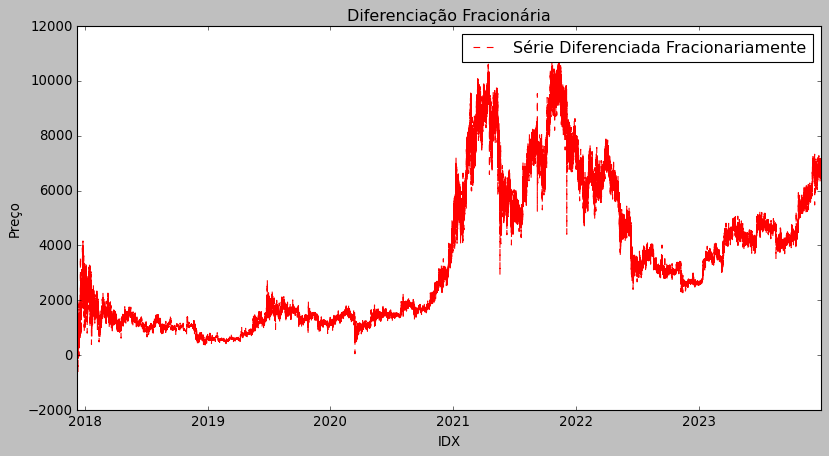

In [ ]:
# Ajusta o plot para comparar as séries
plt.figure(figsize=(12,6))
plt.plot(frac_close.index, frac_close, label='Série Diferenciada Fracionariamente', linestyle='--', color='red')
plt.title('Diferenciação Fracionária')
plt.xlabel('IDX')
plt.ylabel('Preço')
plt.legend()
plt.show()

# ADF Test for Frac-Diff

In [ ]:
adf_stat(frac_close.dropna(), n=50, downsample=False)

ADF Statistic: -3.377255510768961
p-value: 0.011759101946398369
Critical Value (1%): -3.430
Critical Value (5%): -2.862
Critical Value (10%): -2.567
Rejected the null hypothesis - time series is stationary.


True

In [ ]:
df.reset_index(drop=True, inplace=True)
df

,open,high,low,close,volume,dollar_volume,time_diff,diff_time_minutes,hl_vol_k1,hl_vol_k2,frac_close
0,4261.48,4485.39,3850.00,4046.12,2355.171774,1.000498e+07,NaT,NaN,0.091737,0.243757,NaN
1,4046.12,4219.39,3400.00,4168.01,2498.229214,1.000075e+07,3 days 15:05:26.871000,5225.447850,0.129670,0.344551,NaN
2,4168.01,4453.91,4069.80,4332.09,2360.227717,1.000079e+07,3 days 23:07:59.844000,5707.997400,0.054164,0.143920,NaN
3,4352.34,4647.51,4124.54,4578.94,2255.671823,1.000033e+07,3 days 15:49:24.320000,5269.405333,0.071693,0.190498,NaN
4,4578.94,4939.19,4286.87,4652.57,2155.913947,1.000010e+07,3 days 03:57:36.130000,4557.602167,0.085066,0.226032,NaN
...,...,...,...,...,...,...,...,...,...,...,...
377847,42284.00,42305.08,42252.37,42252.38,236.707640,1.000732e+07,0 days 00:20:29.044000,20.484067,0.000749,0.001989,6854.534042
377848,42252.38,42308.69,42218.87,42223.31,236.807080,1.000612e+07,0 days 00:38:55.049000,38.917483,0.001276,0.003391,6837.745921
377849,42223.32,42223.32,42079.97,42141.10,237.311180,1.000038e+07,0 days 00:09:46.531000,9.775517,0.002042,0.005427,6898.850115
377850,42140.86,42241.24,42118.04,42224.52,237.523510,1.002255e+07,0 days 00:15:06.428000,15.107133,0.001754,0.004661,6840.803063


Número ótimo de componentes (95% da variância explicada): 1


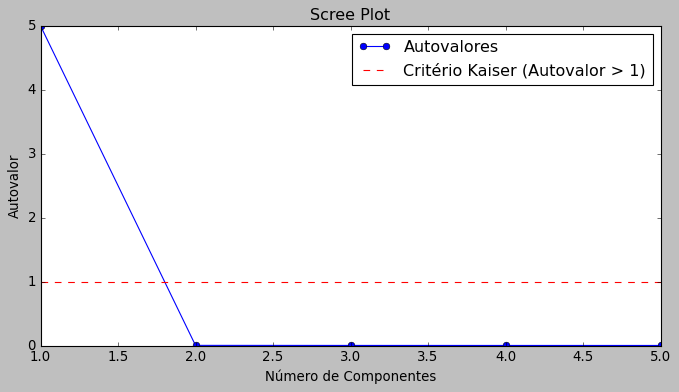

Forma da matriz após PCA: (377648, 1)
MSE médio (5-fold CV): 9627.7797


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

series = frac_close.dropna()

# ======== 2. Criar Matriz de Lags ========
n_lags = 5  # Número inicial de lags
X = np.column_stack([np.roll(series, i) for i in range(1, n_lags + 1)])  # Matriz de lags
X = X[n_lags:]  # Remover NaNs causados pelo shift
y = series[n_lags:]  # Variável alvo ajustada

# ======== 3. Aplicar PCA ========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normalizar os dados
pca = PCA()
X_pca = pca.fit_transform(X_scaled)  # Ajustar PCA

# Variância explicada acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# ======== 4. Determinar Número de Componentes ========
# Método 1: Variância Explicada Acumulada (Exemplo: 95%)
n_components_var = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Número ótimo de componentes (95% da variância explicada): {n_components_var}")

# Método 2: Scree Plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o', label="Autovalores")
plt.axhline(y=1, color='r', linestyle='--', label="Critério Kaiser (Autovalor > 1)")
plt.title("Scree Plot")
plt.xlabel("Número de Componentes")
plt.ylabel("Autovalor")
plt.legend()
plt.show()

# ======== 5. Reduzir Dimensionalidade ========
n_components = n_components_var  # Escolha com base em um dos métodos acima
pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_scaled)  # Dados reduzidos
print(f"Forma da matriz após PCA: {X_reduced.shape}")

# ======== 6. Aplicação em Modelagem ========
# Exemplo: Regressão Linear usando os componentes reduzidos
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

model = LinearRegression()
scores = cross_val_score(model, X_reduced, y, cv=5, scoring='neg_mean_squared_error')
print(f"MSE médio (5-fold CV): {-np.mean(scores):.4f}")

In [ ]:
X_reduced = pd.DataFrame(X_reduced)
order = 1
Y, constant, params = auto_reg(order, X_reduced)

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.652e+09
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:14:21   Log-Likelihood:             8.3281e+05
No. Observations:              377647   AIC:                        -1.666e+06
Df Residuals:                  377645   BIC:                        -1.666e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.711e-05   4.34e-05      0.394      0.6

/Users/felipe/Desktop/orion-mlp/utils/data_analysis.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  constant, params = result.params[0], result.params[:0:-1]


In [ ]:
df

,open,high,low,close,volume,dollar_volume,time_diff,diff_time_minutes,hl_vol_k1,hl_vol_k2,frac_close,close_error
0,4261.48,4485.39,3850.00,4046.12,2355.171774,1.000498e+07,NaT,NaN,0.091737,0.243757,NaN,0.000000
1,4046.12,4219.39,3400.00,4168.01,2498.229214,1.000075e+07,3 days 15:05:26.871000,5225.447850,0.129670,0.344551,NaN,0.031670
2,4168.01,4453.91,4069.80,4332.09,2360.227717,1.000079e+07,3 days 23:07:59.844000,5707.997400,0.054164,0.143920,NaN,-0.115109
3,4352.34,4647.51,4124.54,4578.94,2255.671823,1.000033e+07,3 days 15:49:24.320000,5269.405333,0.071693,0.190498,NaN,-0.006997
4,4578.94,4939.19,4286.87,4652.57,2155.913947,1.000010e+07,3 days 03:57:36.130000,4557.602167,0.085066,0.226032,NaN,0.075101
...,...,...,...,...,...,...,...,...,...,...,...,...
377847,42284.00,42305.08,42252.37,42252.38,236.707640,1.000732e+07,0 days 00:20:29.044000,20.484067,0.000749,0.001989,6854.534042,NaN
377848,42252.38,42308.69,42218.87,42223.31,236.807080,1.000612e+07,0 days 00:38:55.049000,38.917483,0.001276,0.003391,6837.745921,NaN
377849,42223.32,42223.32,42079.97,42141.10,237.311180,1.000038e+07,0 days 00:09:46.531000,9.775517,0.002042,0.005427,6898.850115,NaN
377850,42140.86,42241.24,42118.04,42224.52,237.523510,1.002255e+07,0 days 00:15:06.428000,15.107133,0.001754,0.004661,6840.803063,NaN


In [ ]:
df['close_error'] = Y['fraqdiff_pred'] - X_reduced[0]

In [ ]:
from fredapi import Fred
import matplotlib.pyplot as plt
from datetime import date
import datetime as dt
# import pandas as pd
# import numpy as np

fred = Fred(api_key='5410fb893c641d0a51b804b1a19c1d06')
data = fred.get_series_first_release('GDP')
data.tail()

data1 = fred.get_series_latest_release('GDP') #PIB
data1.tail()


df2 = fred.get_series_latest_release('WM2NS') #agregado M2

payroll = fred.get_series_latest_release('ADPWNUSNERSA') #payroll

cpi = fred.get_series_latest_release('CPIAUCSL') #CPI
cpi = fred.get_series('CPIAUCSL')

ten_year = fred.get_series('DGS10')
ten_year.tail()

two_year = fred.get_series('DGS2')
two_year.tail()

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


2024-11-20    4.31
2024-11-21    4.34
2024-11-22    4.37
2024-11-25    4.21
2024-11-26    4.21
dtype: float64

In [6]:
class PurgedKFold:
    """
    Implements Purged K-Fold Cross-Validation with Embargoing.
    """
    def __init__(self, n_splits=5, purge_size=0, embargo_pct=0.0):
        """
        Parameters:
        - n_splits: int, Number of folds.
        - purge_size: int, Number of samples to purge before the test set.
        - embargo_pct: float, Proportion of samples to embargo after the test set.
        """
        from sklearn.model_selection import KFold

        self.n_splits = n_splits
        self.purge_size = purge_size
        self.embargo_pct = embargo_pct

    def split(self, X):
        """
        Splits the data into train/test indices with purging and embargoing.

        Parameters:
        - X: array-like, Dataset of shape (n_samples,).

        Returns:
        - List of (train_indices, test_indices) tuples.
        """
        n_samples = len(X)
        embargo_size = int(n_samples * self.embargo_pct)
        kf = KFold(n_splits=self.n_splits, shuffle=False)

        splits = []
        for train_indices, test_indices in kf.split(X):
            # Start and end of the test set
            test_start = test_indices[0]
            test_end = test_indices[-1] + 1

            # Purge: Remove data before the test set
            purge_start = max(0, test_start - self.purge_size)

            # Embargo: Remove data after the test set
            embargo_end = min(n_samples, test_end + embargo_size)

            # Remove purged and embargoed regions from train indices
            train_indices = train_indices[(train_indices < purge_start) | (train_indices >= embargo_end)]
            splits.append((train_indices, test_indices))

        return splits

In [12]:
# Simular dados
from sklearn.model_selection import KFold

data = np.arange(1, 210)  # 20 amostras

n_splits = 5  # Dividir em x folds
purge_size = 10  # Remover y amostras antes do teste
embargo_pct = 0.1  # Remover z% após o teste

# Inicializar PurgedKFold
pkf = PurgedKFold(n_splits=n_splits, purge_size=purge_size, embargo_pct=embargo_pct)

# Gerar divisões
splits = pkf.split(data)

# Visualizar os resultados
for fold, (train_idx, test_idx) in enumerate(splits):
    print(f"Fold {fold + 1}")
    print(f"Train: {data[train_idx]}")
    print(f"Test: {data[test_idx]}")

    df_train = data[train_idx].copy()

    # # ACF plot
    # fig, ax = plt.subplots(figsize=(10,6))
    # plot_acf(df_train['frac_close'], lags=50, ax=ax)
    # plt.title('Autocorrelation Function (ACF)')
    # plt.show()

    # # PACF plot
    # fig, ax = plt.subplots(figsize=(10,6))
    # plot_pacf(df_train['frac_close'], lags=50, ax=ax, method='ywm')
    # plt.title('Partial Autocorrelation Function (PACF)')
    # plt.show()

    # df_test = df.iloc[test_idx].copy()








Fold 1
Train: [ 63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209]
Test: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Fold 2
Train: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131

# Feature Engineering
Calculate technical indicators and features for modeling.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Model selection
d = q = 0
p = range(9, 16)
pdq = [(x, d, q) for x in p]

best_aic = np.inf
best_order = None
best_mdl = None

for order in pdq:
    try:
        tmp_mdl = ARIMA(df_frac, order=order).fit()
        tmp_aic = tmp_mdl.aic
        if tmp_aic < best_aic:
            best_aic = tmp_aic
            best_order = order
            best_mdl = tmp_mdl
    except Exception as e:
        continue

print(f'Best ARIMA{best_order} model - AIC:{best_aic}')


Best ARIMANone model - AIC:inf


# Labeling
Apply labeling for supervised learning. We label the data based on future returns.

In [ ]:
if not data_bars.empty:
    # Function to apply labels based on future returns
    def apply_labels(df, threshold=0.005, n_bars=5):
        """
        Label the data based on future returns.
        """
        df = df.copy()
        df['future_return'] = df['close'].shift(-n_bars) / df['close'] - 1
        df['label'] = 0
        df.loc[df['future_return'] > threshold, 'label'] = 1
        df.loc[df['future_return'] < -threshold, 'label'] = -1
        df = df.dropna(subset=['future_return'])
        return df

    # Apply labeling
    data_bars = apply_labels(data_bars, threshold=0.005, n_bars=5)

    # Check label distribution
    print("Label distribution:")
    print(data_bars['label'].value_counts())

    # Visualize label distribution
    data_bars['label'].value_counts().plot(kind='bar')
    plt.title('Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()
else:
    print("No data bars available for labeling.")


NameError: name 'data_bars' is not defined

# Exploratory Data Analysis (EDA)
## Calculate Returns
We calculate log returns and plot them.

In [ ]:
# Calculate log returns
data_bars['log_return'] = np.log(data_bars['close'] / data_bars['close'].shift(1))

# Drop NaN values resulting from calculations
data_bars = data_bars.dropna()

# Plot log returns
plt.figure(figsize=(12,6))
plt.plot(data_bars['time'], data_bars['log_return'])
plt.title('Log Returns')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.show()

## Histogram of Returns
Plot the histogram of returns to analyze the distribution.

In [ ]:
# Histogram of returns
plt.figure(figsize=(10,6))
plt.hist(data_bars['log_return'], bins=50, density=True, alpha=0.6, color='g')

# Fit a normal distribution
mu, std = stats.norm.fit(data_bars['log_return'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('Histogram of Log Returns')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.show()

print(f"Mean: {mu}, Standard Deviation: {std}")

## QQ Plot
Plot a QQ plot to compare the returns distribution with a normal distribution.

In [ ]:
# QQ plot
sm.qqplot(data_bars['log_return'], line='s')
plt.title('QQ Plot of Log Returns')
plt.show()

## Normality Test
Perform the Shapiro-Wilk test for normality.

In [ ]:
# Shapiro-Wilk test
stat, p_value = stats.shapiro(data_bars['log_return'])
print(f"Shapiro-Wilk Test Statistic: {stat}, p-value: {p_value}")

if p_value > 0.05:
    print("Failed to reject the null hypothesis - data is normally distributed.")
else:
    print("Rejected the null hypothesis - data is not normally distributed.")

# Prepare Data for Modeling
Select features and prepare the dataset for training.

In [ ]:

if not data_bars.empty:
    # Select features
    features = ['log_return', 'ma_5', 'ma_10', 'ma_20', 'ma_150', 'ma_161', 'ma_200', 'volatility', 'rsi']

    # Check for missing features
    missing_features = [feat for feat in features if feat not in data_bars.columns]
    if missing_features:
        print(f"Missing features: {missing_features}")

    # Drop NaNs
    data_bars = data_bars.dropna(subset=features + ['label'])

    # Define X and y
    X = data_bars[features]
    y = data_bars['label'] # unico alvo? !!!!!!!

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)  # Transforms -1,0,1 to 0,1,2

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.astype(np.float32))
    X_scaled = pd.DataFrame(X_scaled, columns=features)
else:
    print("No data bars available for modeling.")


# K-Fold Cross-Validation
Use TimeSeriesSplit for cross-validation and train a model.

In [ ]:
if not data_bars.empty and not X_scaled.empty:
    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5) # Usa TimeSeriesSplit !!!!!!!!
    scores = []
    models = []
    feature_importances = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X_scaled), 1):
        print(f"\nTraining fold {fold}")
        X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Check label distribution in y_train
        unique_classes, counts = np.unique(y_train, return_counts=True)
        class_labels = le.inverse_transform(unique_classes)
        print(f"Classes in y_train: {dict(zip(class_labels, counts))}")

        if len(unique_classes) < 2:
            print(f"Not enough classes in y_train for fold {fold}. Skipping this fold.")
            continue  # Skip this fold

        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=fold)
        clf.fit(X_train, y_train)

        # Evaluate
        y_pred = clf.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        print(f"Fold {fold} accuracy: {score}")
        scores.append(score)
        models.append(clf)

        # Feature importance
        importance = pd.Series(clf.feature_importances_, index=features)
        feature_importances.append(importance)

        # Classification report
        print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))
else:
    print("No data available for cross-validation.")


# Evaluate Model Performance
Calculate the average accuracy across folds and analyze feature importance.

In [ ]:
if scores:
    average_score = np.mean(scores)
    print(f"\nAverage accuracy: {average_score}")
else:
    print("No valid folds were found. Please adjust your data or cross-validation strategy.")

# Aggregate feature importances
if feature_importances:
    avg_importance = pd.concat(feature_importances, axis=1).mean(axis=1)
    avg_importance.sort_values().plot(kind='barh')
    plt.title('Average Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()


# Feature Importance Analysis
Analyze feature importance using recursive feature elimination (RFE).

In [ ]:
if not data_bars.empty and not X_scaled.empty:
    # Perform RFE with Random Forest on the entire dataset
    clf_full = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rfecv = RFECV(estimator=clf_full, step=1, cv=TimeSeriesSplit(n_splits=5), scoring='accuracy', n_jobs=-1)
    rfecv.fit(X_scaled, y_encoded)

    # Optimal number of features
    print(f"Optimal number of features: {rfecv.n_features_}")

    # Selected features
    selected_features = X_scaled.columns[rfecv.support_]
    print(f"Selected features: {list(selected_features)}")

    # Plot number of features vs cross-validation scores
    plt.figure(figsize=(10, 6))
    plt.plot(
        range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
        rfecv.cv_results_['mean_test_score']
    )
    plt.xlabel("Number of Features Selected")
    plt.ylabel("Cross-Validation Score (Accuracy)")
    plt.title("RFECV - Number of Features vs. Cross-Validation Score")
    plt.show()
else:
    print("No data available for feature importance analysis.")


# Retrain Model with Selected Features

In [ ]:
if not data_bars.empty and not X_scaled.empty and 'selected_features' in locals():
    # Retrain model with selected features
    X_selected = X_scaled[selected_features]

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    scores_selected = []
    models_selected = []

    for fold, (train_index, test_index) in enumerate(tscv.split(X_selected), 1):
        print(f"\nTraining fold {fold} with selected features")
        X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Check label distribution in y_train
        unique_classes, counts = np.unique(y_train, return_counts=True)
        class_labels = le.inverse_transform(unique_classes)
        print(f"Classes in y_train: {dict(zip(class_labels, counts))}")

        if len(unique_classes) < 2:
            print(f"Not enough classes in y_train for fold {fold}. Skipping this fold.")
            continue  # Skip this fold

        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=fold)
        clf.fit(X_train, y_train)

        # Evaluate
        y_pred = clf.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        print(f"Fold {fold} accuracy: {score}")
        scores_selected.append(score)
        models_selected.append(clf)

        # Classification report
        print(classification_report(y_test, y_pred, target_names=le.classes_.astype(str)))
else:
    print("No data available to retrain model with selected features.")


# Ensembling
Combine predictions from multiple models.

In [ ]:
from scipy.stats import mode

if models_selected:
    # Collect predictions from each model
    ensemble_predictions = []

    for model in models_selected:
        y_pred = model.predict(X_selected)
        ensemble_predictions.append(y_pred)

    # Majority vote
    ensemble_predictions = np.array(ensemble_predictions)
    # Set keepdims=True to preserve the dimensions
    ensemble_majority_vote = mode(ensemble_predictions, axis=0, keepdims=True).mode[0]

    # Decode labels
    ensemble_labels = le.inverse_transform(ensemble_majority_vote)

    # Adjust data_bars to match the length of ensemble_labels
    data_bars_ensemble = data_bars.iloc[len(data_bars) - len(ensemble_labels):].copy()
    data_bars_ensemble['ensemble_prediction'] = ensemble_labels

    # Check the distribution of ensemble predictions
    print("Ensemble prediction distribution:")
    print(data_bars_ensemble['ensemble_prediction'].value_counts())
else:
    print("No models available for ensembling.")


# Risk Management and Backtesting
Implement risk management techniques and evaluate the strategy.

In [ ]:
if not data_bars_ensemble.empty:
    # Set initial capital and other parameters
    initial_capital = 100000  # Starting capital in dollars
    position_size = 0.1       # Fraction of capital to allocate per trade
    max_drawdown = 0.2        # Maximum allowable drawdown
    stop_loss = 0.02          # Stop loss threshold (2%)
    take_profit = 0.04        # Take profit threshold (4%)

    # Initialize variables
    capital = initial_capital
    positions = []
    equity_curve = []

    # Backtesting with risk management
    for idx, row in data_bars_ensemble.iterrows():
        signal = row['ensemble_prediction']
        price = row['close']
        time = row['time']

        # Check for open positions
        if positions:
            # Update position returns
            for position in positions.copy():
                current_return = (price - position['entry_price']) / position['entry_price'] * position['signal']
                position['current_return'] = current_return

                # Check for stop loss or take profit
                if current_return <= -stop_loss or current_return >= take_profit:
                    # Close position
                    profit_loss = position['quantity'] * (price - position['entry_price']) * position['signal']
                    capital += profit_loss + position['reserved_capital']
                    positions.remove(position)
                    print(f"{time} - Closed position: P&L={profit_loss:.2f}, Capital={capital:.2f}")

        # Check if we can open a new position
        if signal != 0 and len(positions) == 0:
            # Calculate available capital and position size
            available_capital = capital * position_size
            quantity = available_capital / price

            # Open new position
            position = {
                'entry_price': price,
                'quantity': quantity,
                'entry_time': time,
                'signal': signal,
                'current_return': 0,
                'reserved_capital': available_capital
            }
            positions.append(position)
            capital -= available_capital
            print(f"{time} - Opened position: Quantity={quantity:.4f}, Entry Price={price:.2f}, Capital={capital:.2f}")

        # Record equity
        net_liquidation = capital + sum([pos['quantity'] * price * pos['signal'] for pos in positions]) + sum([pos['reserved_capital'] for pos in positions])
        equity_curve.append({'time': time, 'equity': net_liquidation})

        # Check for maximum drawdown
        equity_values = [e['equity'] for e in equity_curve]
        peak_equity = max(equity_values)
        drawdown = (peak_equity - net_liquidation) / peak_equity if peak_equity > 0 else 0
        if drawdown > max_drawdown:
            # Close all positions
            for position in positions.copy():
                profit_loss = position['quantity'] * (price - position['entry_price']) * position['signal']
                capital += position['quantity'] * price * position['signal'] + position['reserved_capital']
                positions.remove(position)
                print(f"{time} - Forced close due to drawdown: P&L={profit_loss:.2f}, Capital={capital:.2f}")
            print(f"{time} - Max drawdown exceeded. All positions closed.")
            break  # Stop trading

    # Convert equity curve to DataFrame
    equity_df = pd.DataFrame(equity_curve)
else:
    print("No data available for backtesting.")


# Plot Equity Curve

In [ ]:
if not equity_df.empty:
    # Plot equity curve
    plt.figure(figsize=(12,6))
    plt.plot(equity_df['time'], equity_df['equity'])
    plt.title('Equity Curve with Risk Management')
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.show()
else:
    print("No equity data to plot.")


# Compute Performance Metrics
Calculate the Sharpe ratio and other performance metrics.

In [ ]:
from scipy.stats import mode

if models_selected:
    # Collect predictions from each model
    ensemble_predictions = []

    for model in models_selected:
        y_pred = model.predict(X_selected)
        ensemble_predictions.append(y_pred)

    # Majority vote
    ensemble_predictions = np.array(ensemble_predictions)
    # Set keepdims=True to preserve the dimensions
    mode_result = mode(ensemble_predictions, axis=0, keepdims=True)
    ensemble_majority_vote = mode_result.mode[0]

    # Verify shapes
    print("Shape of ensemble_predictions:", ensemble_predictions.shape)
    print("Shape of ensemble_majority_vote:", ensemble_majority_vote.shape)

    # Decode labels
    ensemble_labels = le.inverse_transform(ensemble_majority_vote)

    # Adjust data_bars to match the length of ensemble_labels
    data_bars_ensemble = data_bars.iloc[len(data_bars) - len(ensemble_labels):].copy()
    data_bars_ensemble['ensemble_prediction'] = ensemble_labels

    # Check the distribution of ensemble predictions
    print("Ensemble prediction distribution:")
    print(data_bars_ensemble['ensemble_prediction'].value_counts())
else:
    print("No models available for ensembling.")


if not equity_df.empty:
    # Compute returns
    equity_df['returns'] = equity_df['equity'].pct_change().fillna(0)

    # Calculate Sharpe Ratio
    sharpe_ratio = np.mean(equity_df['returns']) / np.std(equity_df['returns']) * np.sqrt(252)
    print(f"Sharpe Ratio: {sharpe_ratio}")

    # Maximum Drawdown
    equity_df['cumulative_max'] = equity_df['equity'].cummax()
    equity_df['drawdown'] = (equity_df['cumulative_max'] - equity_df['equity']) / equity_df['cumulative_max']
    max_drawdown_value = equity_df['drawdown'].max()
    print(f"Maximum Drawdown: {max_drawdown_value * 100:.2f}%")
else:
    print("No equity data available for performance metrics.")


# Live Trading Simulation with Simulated Capital
Simulate live trading using the model's predictions on unseen data.

In [ ]:
if not data_bars.empty and not X_scaled.empty:
    # Perform RFE with Random Forest on the entire dataset
    clf_full = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rfecv = RFECV(estimator=clf_full, step=1, cv=TimeSeriesSplit(n_splits=5), scoring='accuracy', n_jobs=-1)
    rfecv.fit(X_scaled, y_encoded)

    # Optimal number of features
    print(f"Optimal number of features: {rfecv.n_features_}")

    # Selected features
    selected_features = X_scaled.columns[rfecv.support_]
    print(f"Selected features: {list(selected_features)}")

    # Fit the model on the entire dataset using the selected features
    clf_full.fit(X_scaled[selected_features], y_encoded)

    # Now clf_full is fitted and can be used for predictions
else:
    print("No data available for feature importance analysis.")


In [ ]:
# For simplicity, use the model trained on the entire dataset
best_model = clf_full
best_features = selected_features

# Ensure that 'initial_capital', 'stop_loss', 'take_profit', and 'position_size' are defined
# Example:
initial_capital = 500  # Starting capital
stop_loss = 0.1          # 2% stop loss
take_profit = 0.1        # 4% take profit
position_size = 0.2       # Use 10% of capital per trade

# Simulate live trading
live_data = data_bars.copy()
live_data['signal'] = best_model.predict(X_scaled[best_features])

# Initialize variables
capital = initial_capital
positions = []
equity_curve_live = []

for idx, row in live_data.iterrows():
    signal = row['signal']
    price = row['close']
    time = row['time']

    # Check for open positions
    if positions:
        # Update position returns
        for position in positions[:]:  # Use a copy of the list to avoid issues when removing items
            current_return = (price - position['entry_price']) / position['entry_price'] * position['signal']
            position['current_return'] = current_return

            # Check for stop loss or take profit
            if current_return <= -stop_loss or current_return >= take_profit:
                # Close position
                profit_loss = position['quantity'] * (price - position['entry_price']) * position['signal']
                capital += profit_loss + (position['quantity'] * price)  # Add back the capital from the position
                positions.remove(position)
                print(f"{time} - Closed position: P&L={profit_loss:.2f}, Capital={capital:.2f}")

    # Check if we can open a new position
    if signal != 0 and len(positions) == 0:
        # Calculate available capital and position size
        available_capital = capital * position_size
        quantity = available_capital / price

        # Open new position
        position = {
            'entry_price': price,
            'quantity': quantity,
            'entry_time': time,
            'signal': signal,
            'current_return': 0
        }
        positions.append(position)
        capital -= available_capital
        print(f"{time} - Opened position: Quantity={quantity:.4f}, Entry Price={price:.2f}, Capital={capital:.2f}")

    # Record equity
    net_liquidation = capital + sum([pos['quantity'] * price * pos['signal'] for pos in positions])
    equity_curve_live.append({'time': time, 'equity': net_liquidation})

# Convert equity curve to DataFrame
equity_live_df = pd.DataFrame(equity_curve_live)


# Plot Live Equity Curve

In [ ]:
# Plot live equity curve
plt.figure(figsize=(12,6))
plt.plot(equity_live_df['time'], equity_live_df['equity'])
plt.title('Live Trading Equity Curve')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.show()


# Compute Live Trading Performance Metrics

In [ ]:
# Compute returns
equity_live_df['returns'] = equity_live_df['equity'].pct_change()

# Calculate Sharpe Ratio
sharpe_ratio_live = np.mean(equity_live_df['returns']) / np.std(equity_live_df['returns']) * np.sqrt(252)
print(f"Live Trading Sharpe Ratio: {sharpe_ratio_live}")

# Maximum Drawdown
equity_live_df['cumulative_max'] = equity_live_df['equity'].cummax()
equity_live_df['drawdown'] = (equity_live_df['cumulative_max'] - equity_live_df['equity']) / equity_live_df['cumulative_max']
max_drawdown_live = equity_live_df['drawdown'].max()
print(f"Live Trading Maximum Drawdown: {max_drawdown_live * 100:.2f}%")


# Best Model Saving
Save the best model for future use.

In [ ]:
if 'clf_full' in locals():
    # Save the best model and the scaler
    import joblib

    # Create a directory to save the model
    model_dir = 'saved_models'
    os.makedirs(model_dir, exist_ok=True)

    # Save the model and the scaler
    model_path = os.path.join(model_dir, 'best_model.joblib')
    scaler_path = os.path.join(model_dir, 'scaler.joblib')
    joblib.dump(clf_full, model_path)
    joblib.dump(scaler, scaler_path)

    print(f"Best model saved to {model_path}")
    print(f"Scaler saved to {scaler_path}")
else:
    print("No model available to save.")


# Time Series Modeling - UNDER DEVELOPEMENT, JUST IGNORE THE CELLS BELOW
## Split Data into Training and Testing Sets
We split the data for modeling.

In [ ]:
# # Split the data
# split_ratio = 0.8
# split_index = int(len(data_bars) * split_ratio)
# train_data = data_bars['log_return'].iloc[:split_index]
# test_data = data_bars['log_return'].iloc[split_index:]


## Model Selection using AIC and BIC
Determine the best ARIMA model using Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).

In [ ]:
# # Model selection
# p = d = q = range(0, 4)
# pdq = [(x, y, z) for x in p for y in d for z in q]

# best_aic = np.inf
# best_order = None
# best_mdl = None

# for order in pdq:
#     try:
#         tmp_mdl = tsa.ARIMA(train_data, order=order).fit(method='statespace', disp=False)
#         tmp_aic = tmp_mdl.aic
#         if tmp_aic < best_aic:
#             best_aic = tmp_aic
#             best_order = order
#             best_mdl = tmp_mdl
#     except Exception as e:
#         continue

# print(f'Best ARIMA{best_order} model - AIC:{best_aic}')


# Fit the ARIMA Model
Fit the best ARIMA model.

In [ ]:
# # Fit the best model
# model = tsa.ARIMA(train_data, order=best_order)
# model_fit = model.fit()
# print(model_fit.summary())


# Residual Diagnostics
Plot the residuals to check for any patterns.

In [ ]:
# # Residuals plot
# residuals = model_fit.resid
# fig, ax = plt.subplots(2,1, figsize=(12,8))
# residuals.plot(ax=ax[0])
# ax[0].set_title('Residuals')
# residuals.plot(kind='kde', ax=ax[1])
# ax[1].set_title('Density of Residuals')
# plt.tight_layout()
# plt.show()


# Forecasting
Forecast the returns using the model.

In [ ]:
# # Forecast
# forecast_steps = len(test_data)
# forecast_result = model_fit.get_forecast(steps=forecast_steps)
# forecast_mean = forecast_result.predicted_mean
# forecast_ci = forecast_result.conf_int()

# # Plot forecast vs actual
# plt.figure(figsize=(12,6))
# plt.plot(test_data.index, test_data, label='Actual Returns')
# plt.plot(test_data.index, forecast_mean, label='Forecasted Returns')
# plt.fill_between(test_data.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
# plt.title('ARIMA Model Forecast')
# plt.xlabel('Time')
# plt.ylabel('Log Return')
# plt.legend()
# plt.show()


# Evaluate Model Performance
Calculate the Mean Squared Error (MSE) and Mean Absolute Error (MAE).

In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # Calculate errors
# mse = mean_squared_error(test_data, forecast_mean)
# mae = mean_absolute_error(test_data, forecast_mean)
# print(f'Mean Squared Error: {mse}')
# print(f'Mean Absolute Error: {mae}')